In [1]:
%matplotlib notebook

In [2]:
from astropy.io import fits
import numpy as np
from der_snr import DER_SNR
from astropy.stats import sigma_clip
from matplotlib import pyplot as plt
from ipywidgets import IntSlider, interact, Dropdown, Button, HBox
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from ppxf import ppxf_util, ppxf
import glob
from astropy import constants as const
import matplotlib.transforms as mtransforms


class CubeSpec(object):
    def __init__(self, cube, lam):
        """
        Class initiator
        
        Takes a 3D numpy array as cube and a wavelength array
        """
        # Cube parameters
        self.cube = cube
        self.lam = lam
        self.lamrange = [self.lam[0], self.lam[-1]]
        self.xs, self.ys, self.naxis = self.cube.shape
        
        # Sepctrum parameters
        self.snr_spec = {}
        self.sefinal_spec = np.zeros(1000)
        self.left_click_locatio = None
        self.regions = []
        self.goodPixels = []
        self.cid = None
        self.current_snr = 0
        
        # Maps
        self.snMap = np.zeros((self.xs,self.ys))
        self.lightMap = np.zeros((self.xs,self.ys))
        self.snList = np.zeros((3,self.xs*self.ys))
        
        # ppxf parameters
        self.pp = None
        self.redshift = 2472
        self.start = [self.redshift, 10.]
        self.galaxy = None
        self.logLam1 = None
        self.vscale = None
        self.templates = None

    def make_snarry(self):
        """
        Calculate the SNR of the cube
        """   
        # Make SN array
        c=0
        for i in range(self.xs):
            for j in range(self.ys):
                spec=self.cube[i,j,:]
                self.snMap[i,j]=DER_SNR(spec)
                self.snList[:,c]=[i,j,DER_SNR(spec)]
                filteredData = sigma_clip(spec, sigma=3, maxiters=1)
                spax_mean = np.mean(filteredData.data[~filteredData.mask])
                self.lightMap[i,j]= spax_mean
                c+=1
                
    def slice_plot(self, slice_num):
        """
        Display one slice of the cube based on the slice_num
        """
        cube_im.set_data(self.cube[:,:,slice_num])
        fig_cube.canvas.draw()
        
    def spec_plot(self, snr):
        """
        Callback for the SNR dialog

          1. Update the spectrum based on the input SNR
          2. Update the SNR map based on the input SNR
          3. Update the kinematics plot
        """
        # snr can be given as a dictionary from the drop-down
        if isinstance(snr, dict):
            snr = float(snr['new'])
        else:
            snr =  float(snr)

        #
        # 1. Update the spectrum
        #

        if snr in self.snr_spec.keys():
            new_spec = self.snr_spec[snr]
        else:
            new_spec = self.calc_spec_snr(snr)
        
        
        new_snr = DER_SNR(new_spec)
        self.final_spec = new_spec
        self.current_snr = snr
        self.log_rebin()
        ax_spec.cla()
        ax_spec.plot(self.lam, self.galaxy)
        ax_spec.set_title('Combined spectrum ({} points). New S/N: {:0.2f}'.format((self.snMap >= snr).sum(), new_snr))
        fig_spec.canvas.draw()


        #
        #  2. Update the SNR map
        #

        mask = self.snMap >= snr
        map.mask = mask
        map_im.set_data(map)

        #
        # 3. Update the Kinematics map
        #
        if (np.sum(self.final_spec) > 0) and ('ax_fit' in globals()):
            self.run_ppxf()

    def calc_spec_snr(self, snr):
        """
        Calculate the mean spectrum from the input SNR
        and updates the dictionary
        """

        # Calculate the new spectrum based on the SNR
        find = np.where(self.snMap >= snr)
        selection = self.cube[find[0], find[1], :]
        new_spec = np.mean(selection, axis=0)

        # Add the new spectrum the global dictionary
        self.snr_spec[snr] = new_spec

        return new_spec
    
    def log_rebin(self):
        """
        Rebins current final_spec to a log scale
        """
        self.galaxy, self.logLam1, self.vscale = ppxf_util.log_rebin(self.lamrange, self.final_spec)
        self.noise = self.galaxy*0 + 1

    def run_ppxf(self):
        """
        Runs the ppxf for the final_spec and the templates 
        Creates the goodPixels from the selected regions
        """
        # Define goodPixels
        if self.regions:
            self.goodPixels = np.sort(np.hstack(np.array([np.arange(int(start), int(stop)) for start,stop in self.regions])))
        else:
            self.goodPixels = np.arange(0,len(self.final_spec))
        
        # Rebin
        self.log_rebin()
        
        # Do the ppxf
        self.pp = ppxf.ppxf(templates, self.galaxy, self.noise, self.vcale, self.start,
                      goodpixels=self.goodPixels, plot=False, degree=4, moments=2, lam = self.lam, vsyst=dv)
        self.plot_ppxf(self.pp)

    def plot_ppxf(self,pp):
        """
        Plots the ppxf fit output (copy pasted from the ppxf code itself)
        """
        
        # Clear axes
        ax_fit.cla()
        
        # Do the plot
        if pp.lam is None:
            ax_fit.set_xlabel("Pixels")
            x = np.arange(pp.galaxy.size)
        else:
            ax_fit.set_xlabel(r"Wavelength [$\AA$]")
            x = pp.lam
            
        # Plot data and fit
        ll, rr = np.min(x[pp.goodpixels]), np.max(x[pp.goodpixels])
        mn, mx = np.min(pp.bestfit[pp.goodpixels]), np.max(pp.bestfit[pp.goodpixels])
        resid = mn + pp.galaxy - pp.bestfit
        mn1 = np.min(resid[pp.goodpixels])
        ax_fit.set_ylabel("Counts")
        ax_fit.set_xlim([ll, rr] + np.array([-0.02, 0.02])*(rr - ll))
        ax_fit.set_ylim([mn1, mx] + np.array([-0.05, 0.05])*(mx - mn1))
        ax_fit.plot(x, pp.galaxy, 'k')
        ax_fit.plot(x, pp.bestfit, 'Tomato', linewidth=2)
        ax_fit.plot(x[pp.goodpixels], resid[pp.goodpixels], 'd', color='YellowGreen', mec='YellowGreen', ms=4)
        ax_fit.plot(x[pp.goodpixels], pp.goodpixels*0 + mn, '.k', ms=1)
        ax_fit.set_title('Vel = {:0.2f}, Disp = {:0.2f}'.format(pp.sol[0], pp.sol[1]))
        
        # Plot residuals
        w = np.flatnonzero(np.diff(pp.goodpixels) > 1)
        if w.size > 0:
            for wj in w:
                j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
                ax_fit.plot(x[j], resid[j], 'SteelBlue')
            w = np.hstack([0, w, w + 1, -1])  # Add first and last point
        else:
            w = [0, -1]
        for gj in pp.goodpixels[w]:
            ax_fit.plot(x[[gj, gj]], [mn, pp.bestfit[gj]], 'YellowGreen')
        
    def fig_spec_button_press(self, event):
        """
        Callback to the region selection
        Left mouse click marks the lower limit of the region
        Right mouse click marks the upper limit and exists the region selection mode
        """
        # Left mouse click
        if event.button == 1:
            ax_spec.axvline(event.xdata, color='DarkGreen')
            ind = np.argsort(np.abs(self.lam-event.xdata))[0]
            self.left_click_location = ind
        # Right mouse click
        if event.button == 3:
            ax_spec.axvline(event.xdata, color='g')
            # Draw a shaded area between the two lines
            trans = mtransforms.blended_transform_factory(ax_spec.transData, ax_spec.transAxes)        
            ax_spec.fill_between(lam, 0, 1, where=((lam >= self.lam[self.left_click_location]) & (self.lam <= event.xdata)),
                    facecolor='green', alpha=0.5, transform=trans)
            ind = np.argsort(np.abs(self.lam-event.xdata))[0]
            # Append to the regions
            self.regions.append([self.left_click_location, ind])
            # Rerun ppxf with the new regions
            self.run_ppxf()
            # Disconnect the mouse clicks and reset the left_click_location
            fig_spec.canvas.mpl_disconnect(self.cid)
            self.left_click_location = None

    def clear_region(self, param):
        """
        Callback to clear all regions button 
        (and redraw and refit spectrum)
        """
        self.regions = []
        self.left_click_location = None
        self.spec_plot(self.current_snr)

    def create_region(self, param):
        """
        Callback to create regions button
        """
        self.cid = fig_spec.canvas.mpl_connect('button_press_event',self.fig_spec_button_press)

## Loading the data

In [3]:
name = '/Users/busko/Dropbox/NGC5406.V1200.rscube.fits'
hdulist = fits.open(name)
if len(hdulist)>1:
    hdu=hdulist[1]
else:
    hdu=hdulist[0]

cube = hdu.data.T #just remember to always transpose with fits files
hdr = hdu.header
print(hdr)

hdr['CRVAL3'] = 0
hdr['Cd3_3'] = 1

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   77                                                  NAXIS2  =                   72                                                  NAXIS3  =                 1701                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'ERROR   '           / extension name                                 END                                                                                                                                                                                                                                                                                     

In [4]:
lam=np.linspace(hdr['CRVAL3'], hdr['CRVAL3'] + hdr['Cd3_3']*(hdr['NAXIS3']-1.), hdr['NAXIS3'])
xs, ys, naxis = cube.shape
cubespec = CubeSpec(cube, lam)
hdulist.close()

## Calculate the signal/noise map

In [5]:
cubespec.make_snarry()

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Users/busko/Projects/dat_pyinthesky_test/jwst_nb_viz/example/der_snr.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return float(signal / noise)
/Use

## Display cube and S/N map

<IPython.core.display.Javascript object>


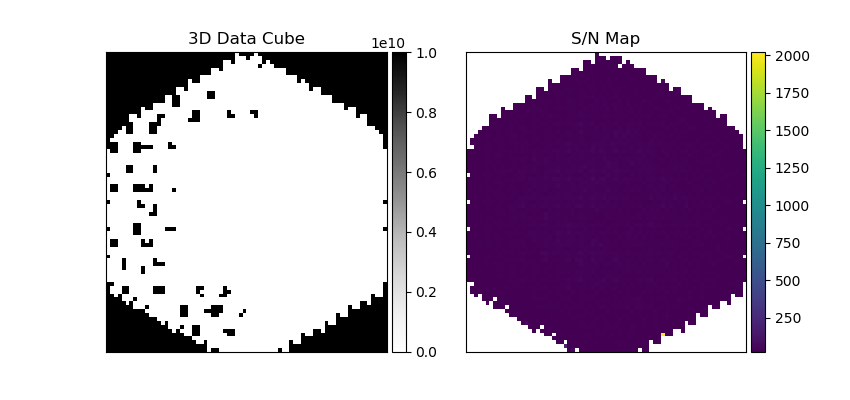

interactive(children=(IntSlider(value=850, description='slice_num', max=1701), Output()), _dom_classes=('widge…

In [6]:
# Create the slider
slider = IntSlider(
    value=int(cubespec.naxis/2.),
    min=0,
    max=cubespec.naxis)

# Create figure and axes
fig_cube = plt.figure(figsize=(8.5,4))
ax_cube = fig_cube.add_subplot(121)
ax_snr = fig_cube.add_subplot(122)
ax_cube.set_xticks([])
ax_cube.set_yticks([])
ax_snr.set_xticks([])
ax_snr.set_yticks([])
ax_cube.set_title('3D Data Cube')
ax_snr.set_title('S/N Map')

# Display the SNR map, not cube
snr_im = ax_snr.imshow(cubespec.snMap, aspect='auto')

# Display the overlay
map = np.ma.masked_array(np.ones_like(cubespec.snMap), mask=True)
map_im = ax_snr.imshow(map, alpha=0.7)
divider = make_axes_locatable(ax_snr)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig_cube.colorbar(snr_im, cax=cax)

# Add the callback for the slice slider for the cube
cube_im = ax_cube.imshow(cubespec.cube[:,:,1500],cmap=cm.get_cmap('Greys'))
divider = make_axes_locatable(ax_cube)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig_cube.colorbar(cube_im, cax=cax)
_ = interact(cubespec.slice_plot, slice_num=slider)

## Calculate and plot the average galaxy spectrum

In [ ]:
# Create the figure and the SNR Dropdown
fig_spec = plt.figure()
ax_spec = fig_spec.add_subplot(111)
show_snr = Dropdown(options=[str(int(x)) for x in np.arange(0, np.max(cubespec.snMap), 10)],
    value='0',
    description='S/N:',
    disabled=False,
)

# Add callback to the dropdown
show_snr.observe(cubespec.spec_plot, names='value')
display(show_snr)

# Create regions
reg_button = Button(description="Create Region",
                    button_style='success')
reg_button.on_click(cubespec.create_region)

# Clear regions
clear_button = Button(description="Clear Region",
                     button_style='warning')
clear_button.on_click(cubespec.clear_region)

# Displaying both buttons next to each other
box = HBox([reg_button, clear_button])
display(box)

# Plot the default spectrum
cubespec.spec_plot(0)

## Load the template library

In [ ]:
# To get the vscale of the galaxy spectrum we need to run this step
cubespec.log_rebin()
# Template dir
specdir='/Users/nluetzge/Science/UCDs/'
Z = 'Z-0.0.Alpha=0.0'
temp_files = glob.glob(specdir+Z+'/nifstemp*fits')
nfiles=len(temp_files)
for i in range(nfiles):
    hdu = fits.open(temp_files[i])
    h_template=hdu[0].header
    temp_lin=hdu[0].data

    # the wavelength range calculated from the header data
    naxis=h_template['NAXIS1']
    lamRange2=h_template['CRVAL1'] + np.array([0.,h_template['CDELT1']*(h_template['NAXIS1']-1.)])

    tt, logLam2,velscale = ppxf_util.log_rebin(lamRange2, temp_lin, velscale=cubespec.vscale)

    if i==0:
        templates=np.zeros((len(tt),nfiles))
        templates_lin=np.zeros((naxis,nfiles))

    templates[:,i]=tt
    templates_lin[:,i]=temp_lin

dv = (logLam2[0]-cubespec.logLam1[0])*const.c.to('km/s').value

In [ ]:
fig_fit = plt.figure()
ax_fit = fig_fit.add_subplot(111)

cubespec.run_ppxf()